In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from getSIDMdata_generator import get_tf_DataSet as getGenerators
import mertens_models as mertens
import pickle as pkl
import scienceplots
plt.style.use(["science", "grid"])

In [ ]:
histories = []
epochs=80
train, test = getGenerators(augment_data=True, simulationNames=['CDM','SIDM0.1','SIDM1'], 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl')
for iRate in np.logspace(-2.5,-2., 2):

    inception_merten = mertens.InceptionV4(input_shape=test[0][0].shape,bn_momentum=.0,classes=len(simulationNames),feature_dropout=.33,num_layersA=1,num_layersB=1,num_layersC=1,leak=.03)
    optimizer = tf.keras.optimizers.Adam( learning_rate=iRate )
    inception_merten.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    history = inception_merten.fit(
      x=train,
      validation_data=test,
      epochs=epochs
    )
    histories.append(inception_merten.history.history)
pkl.dump( histories, open("pickles/learning_rate.pkl", "wb"))



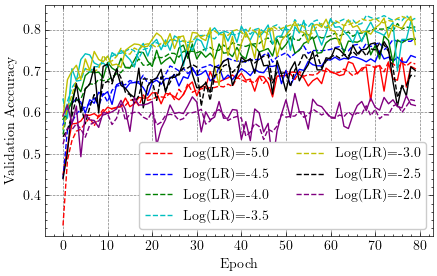

In [7]:
plt.figure(figsize=(5,3))
plt.xlabel('Epoch')
plt.ylabel('Validation Acccuracy')
histories = pkl.load(open("pickles/learning_rate.pkl", "rb"))
c = ['r','b','g','c','y','k','purple']
names =  np.log10(np.logspace(-5,-2, 7))
for i, iModel in enumerate(histories):
    plt.plot(np.arange(len(iModel['val_accuracy'])), iModel['val_accuracy'], c=c[i])
    plt.plot(np.arange(len(iModel['accuracy'])), iModel['accuracy'], label="Log(LR)=%0.1f" % names[i], c=c[i],ls='--')

    #plt.plot(iModel.history.epoch, [np.max(iModel.history.history['val_accuracy'])]*len(iModel.history.epoch), c=c[i])
    #print(np.max(iModel.history.history['val_accuracy']))

plt.legend( ncols=2 )
plt.savefig("../plots/learning_rate.pdf")

## Old version

In [9]:
(train_images, train_att, train_labels), testSets = getData(  indexFileRoot='pickles/testIndexesLR', testTrainSplit=0.15)

1181
nTests is 177
1344
nTests is 201
1153
nTests is 172
1156
nTests is 173


In [10]:
nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]

In [11]:
test_labels, test_images = None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))


FOUND PREVIOUS MODEL, LOADING...
FOUND PREVIOUS MODEL, LOADING...
FOUND PREVIOUS MODEL, LOADING...
FOUND PREVIOUS MODEL, LOADING...
FOUND PREVIOUS MODEL, LOADING...
FOUND PREVIOUS MODEL, LOADING...
FOUND PREVIOUS MODEL, LOADING...


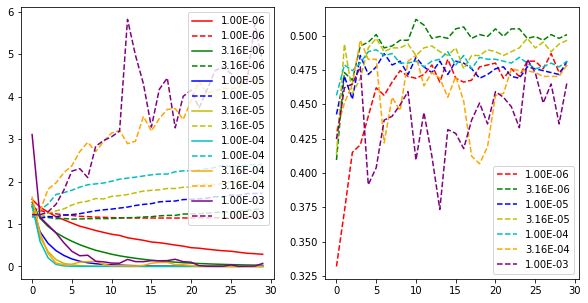

In [15]:
color=['r','g','b','y','c','orange','purple']
fig, [ax1, ax2]  = plt.subplots( 1, 2, figsize=(10,5))

#Test the size of the final flattened layer on the predictability
learningRates = np.logspace(-6, -3, 7)
for i, learning_rate in enumerate(learningRates):
    
    csv_file = 'pickles/testLearningRate_%0.2f.csv' % np.log10(learning_rate)
    csv_logger = CSVLogger(csv_file, append=True)
    model_file =  'pickles/testLearningRate_%0.2f.h5' % np.log10(learning_rate)
    
    if os.path.isfile( csv_file ):
        previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
        initial_epoch = previousEpochs.shape[0]
    else:
        initial_epoch = 0
        
    if os.path.isfile(model_file):
        print("FOUND PREVIOUS MODEL, LOADING...")
        #model = models.load_model(model_file)
    else:
        model = simpleCNN.getModel( inputShape, nClasses, finalLayer=2048, dropout=0.3, learning_rate=learning_rate)
            
        history = model.fit(train_images, train_labels, epochs=30, 
                    initial_epoch=initial_epoch,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
    
        model.save(model_file)
        
    trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
    ax1.plot(trainHistory['loss'], label='%0.2E' % learning_rate, color=color[i])
    ax1.plot(trainHistory['val_loss'], label='%0.2E' % learning_rate, color=color[i], linestyle='--')

    ax2.plot(trainHistory['val_accuracy'], label = '%0.2E' % learning_rate, linestyle='--', color=color[i]) 
ax1.legend()   
ax2.legend()

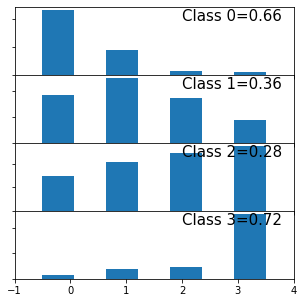

In [17]:
neurons = 256
learning_rate = -5.5
model_file =  'pickles/testFinalLayerDensity_%i.h5' % neurons
model_file =  'pickles/testDropOut_0.00_finalLayer_256.h5'
model_file =  'pickles/testLearningRate_%0.2f.h5' % learning_rate

model = models.load_model(model_file)
prediction = np.argmax(model.predict(test_images),axis=1)

fig, ax = plt.subplots(4,1, figsize=(5,5))
for axis, i in enumerate(np.unique(test_labels)):
    ax[axis].hist(prediction[test_labels[:,0]==i], bins=np.linspace(-0.5,3.5,8), density=True)
    ax[axis].set_xlim(-1,4)
    acc = np.where(prediction[test_labels[:,0]==i]==i)[0].shape[0]/prediction[test_labels[:,0]==i].shape[0]
    ax[axis].text(0.6, 0.8, "Class %i=%0.2f" % (i,acc), transform=ax[axis].transAxes, fontsize=15)
    if i != len(ax)-1:
        ax[axis].set_xticklabels([])
    ax[axis].set_yticklabels([])
    
fig.subplots_adjust(hspace=0)